In [1]:
# first, use Vicky's scripts to generate network graph
import os

print(os.getcwd())

C:\Users\jacob\OneDrive\Documents\GitHub\llms_are_our_friends


In [2]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Folder containing the action movie scripts
action_folder = "Action/Action"

# Read each movie script into a dictionary with the filename as key.
movie_scripts = {}
for filename in os.listdir(action_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(action_folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            movie_scripts[filename] = f.read()

# Prepare the TF-IDF vectorizer: We remove English stop words and limit to the 1000 most important features.
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
titles = list(movie_scripts.keys())
documents = [movie_scripts[title] for title in titles]
tfidf_matrix = vectorizer.fit_transform(documents)

# Compute cosine similarity between the TF-IDF vectors of the scripts.
similarity_matrix = cosine_similarity(tfidf_matrix)

# Create a graph where each node represents a movie script.
G_tfidf = nx.Graph()
threshold = 0.05  # Only consider similarities above this threshold to create an edge

for i in range(len(titles)):
    G_tfidf.add_node(titles[i])
    for j in range(i + 1, len(titles)):
        sim = similarity_matrix[i, j]
        if sim > threshold:
            G_tfidf.add_edge(titles[i], titles[j], weight=sim)

# Visualize the similarity network using a spring layout.
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_tfidf, k=0.5, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G_tfidf, pos, node_color="lightblue", node_size=500)

# Draw edges with widths proportional to similarity
edges = G_tfidf.edges(data=True)
nx.draw_networkx_edges(G_tfidf, pos, width=[d["weight"] * 5 for (_, _, d) in edges])

# Draw node labels (movie titles)
nx.draw_networkx_labels(G_tfidf, pos, font_size=10)

plt.title("Movie Script Similarity Network (Action Movies)")
plt.axis("off")
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Action/Action'

In [10]:
!pip install transformers

  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ------------------- -------------------- 5.0/10.0 MB 30.1 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 29.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 24.9 MB/s eta 0:00:00
Using cached filelock-3.17.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)


In [12]:
!huggingface-cli login

^C


Prompt saved to prompt.txt (not shown here for brevity).

Parsed Associations:
{'15 Minutes': ['48 Hrs.', 'Bad Boys', 'Code of Silence', 'A Most Violent Year'], '2012': ['Armageddon', 'The Book of Eli', 'Dawn of the Dead'], '30 Minutes or Less': ['15 Minutes', 'Bad Boys', 'Austin Powers: International Man of Mystery'], 'A Most Violent Year': ['15 Minutes', 'Code of Silence', 'Deep Cover'], 'Above the Law': ['Code of Silence', 'Cradle 2 the Grave', 'Crouching Tiger', 'Hidden Dragon'], 'Air Force One': ['Collateral Damage', 'Die Hard'], 'Alien 3': ['Alien', 'Aliens', 'Alien vs. Predator', 'Alien: Resurrection'], 'Alien': ['Resurrection:  Alien', 'Aliens', 'Alien 3', 'Alien vs. Predator'], 'Aliens': ['Alien', 'Alien 3', 'Alien vs. Predator', 'Alien: Resurrection', 'The Abyss', 'Avatar'], 'Alone in the Dark': ['Buffy the Vampire Slayer', 'Constantine', 'The Crow'], 'American Outlaws': ['The Bounty Hunter'], 'American Sniper': ['Apocalypse Now', 'Defiance'], 'Apocalypse Now': ['American Sni

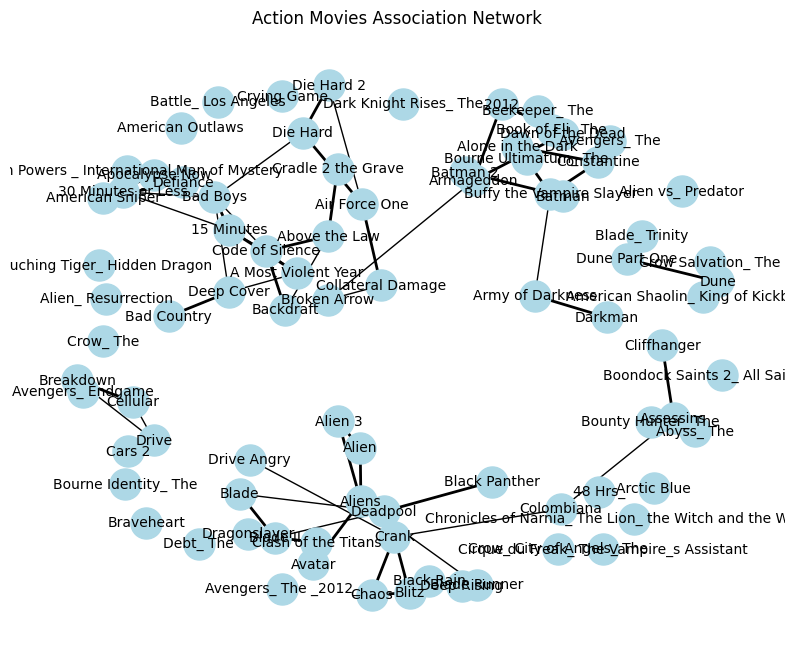

In [25]:
import os
import networkx as nx
import matplotlib.pyplot as plt

# --- Part 1: Extract Short Excerpts from Movie Scripts ---

# Folder with movie scripts
action_folder = "Action/Action"
movie_data = {}  # Dictionary to hold movie name (without extension) and a short excerpt

# For each movie script, we extract the first paragraph and then only the first 100 words as an excerpt.
for filename in os.listdir(action_folder):
    if filename.endswith(".txt"):
        movie_name = os.path.splitext(filename)[0]  # Remove the extension
        file_path = os.path.join(action_folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read().strip()
        # Split on double newlines to get paragraphs, then choose the first non-empty paragraph.
        paragraphs = [p.strip() for p in content.split("\n\n") if p.strip()]
        if paragraphs:
            # Get the first paragraph and take only the first 100 words.
            excerpt_words = paragraphs[0].split()[:100]
            excerpt = " ".join(excerpt_words)
        else:
            excerpt = ""
        movie_data[movie_name] = excerpt

# --- Part 2: Construct the Prompt for the LLM and Save it to a File ---

# The prompt includes a header and each movie's title with its short excerpt.
prompt = (
    "Below are short excerpts from several action movie scripts. "
    "For each movie, identify key descriptive words and generate associations between movies based on the similarities of these words. "
    "For each movie, list the associated movies in the format:\n\n"
    "MovieName: associated with MovieName2, MovieName3, ...\n\n"
)

for movie, excerpt in movie_data.items():
    prompt += f"Movie: {movie}\nExcerpt: {excerpt}\n\n"
prompt += "Associations:\n"

# Save the prompt to a file called "prompt.txt"
with open("prompt.txt", "w", encoding="utf-8") as f:
    f.write(prompt)

print("Prompt saved to prompt.txt (not shown here for brevity).")

# --- Part 3: [LLM Generation Code is Commented Out] ---
# (This section is commented out; you generate the response externally.)
#
# from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
# token = "YOUR_TOKEN_HERE"
# model_name = "mistralai/Mixtral-8x7B-v0.1"
#
# tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=token)
# model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=token, device_map="auto")
# generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
#
# result = generator(prompt, max_length=512, num_return_sequences=1)
# generated_text = result[0]["generated_text"]
# print("\nGenerated Associations:")
# print(generated_text)

# --- Part 4: Read from a Response File and Build the Network Graph ---

# Read the generated associations from the file "response_gpto1.txt"
with open("response_gpto1.txt", "r", encoding="utf-8") as f:
    response_text = f.read()

associations = {}
for line in response_text.splitlines():
    line = line.strip()
    if not line or ":" not in line:
        continue
    # Split on the first colon
    movie_title, assoc_str = line.split(":", 1)
    movie_title = movie_title.strip()
    # Only consider movies present in our movie_data
    if movie_title in movie_data:
        assoc_list = [a.strip() for a in assoc_str.replace("associated with", "").split(",") if a.strip()]
        associations[movie_title] = assoc_list

print("\nParsed Associations:")
print(associations)

# Build a graph: each movie is a node; if movie A is associated with movie B, add an edge.
G_llm = nx.Graph()
for movie in movie_data.keys():
    G_llm.add_node(movie)

for movie, assoc_list in associations.items():
    for assoc in assoc_list:
        if assoc in movie_data:
            # If the edge already exists, increment its weight.
            if G_llm.has_edge(movie, assoc):
                G_llm[movie][assoc]['weight'] += 1
            else:
                G_llm.add_edge(movie, assoc, weight=1)

# --- Part 5: Visualize the Network Graph ---

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_llm, k=0.5, iterations=50)
nx.draw_networkx_nodes(G_llm, pos, node_color="lightblue", node_size=500)
edges = G_llm.edges(data=True)
nx.draw_networkx_edges(G_llm, pos, width=[d["weight"] for (_, _, d) in edges])
nx.draw_networkx_labels(G_llm, pos, font_size=10)
plt.title("Action Movies Association Network")
plt.axis("off")
plt.show()


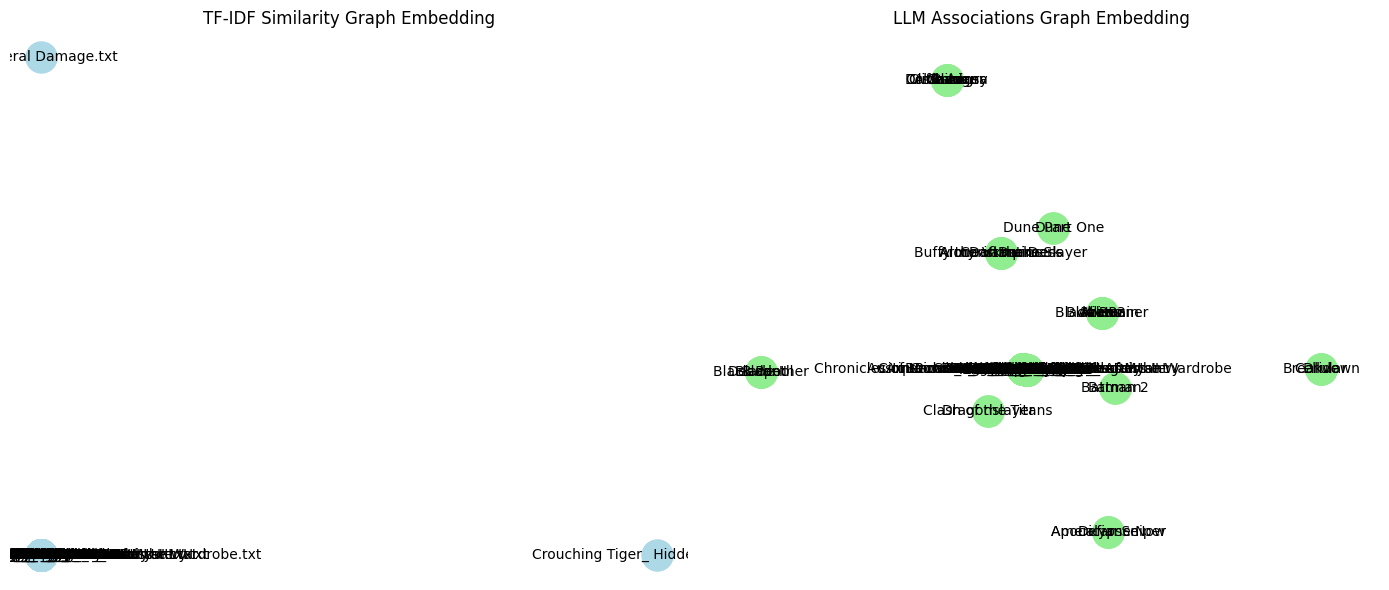

Network Statistics Comparison:
                         num_nodes  num_edges   density  avg_clustering  \
TF-IDF Similarity Graph         83        187  0.054952        0.402678   
LLM Associations Graph          83         55  0.016162        0.273092   

                         avg_degree  avg_shortest_path  
TF-IDF Similarity Graph    4.506024                NaN  
LLM Associations Graph     1.325301                NaN  


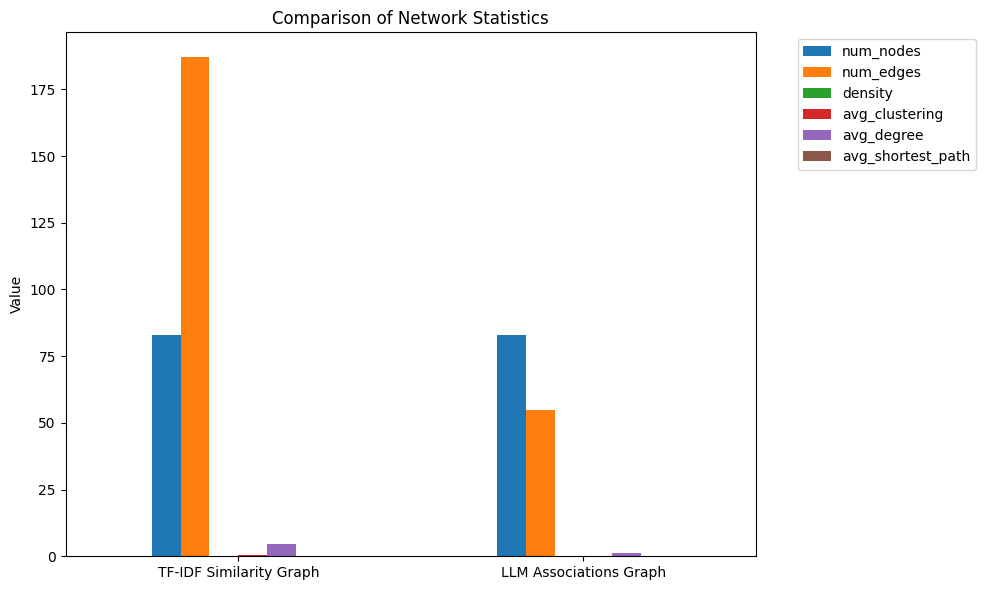

In [26]:
# are the generated representations similar?

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ----- Assume G_tfidf and G_llm have already been built. -----

# For illustration, let's assume these are our graphs.
# (Replace these with your actual graphs.)
# G_tfidf = ...  # graph from TF-IDF similarity
# G_llm = ...    # graph from LLM associations

# --- Graph Embedding Comparison ---
# We use networkx's spectral_layout as a low-level embedding.
# spectral_layout uses the eigenvectors of the Laplacian of the graph.

pos_tfidf = nx.spectral_layout(G_tfidf)
pos_llm = nx.spectral_layout(G_llm)

plt.figure(figsize=(14, 6))

# Plot TF-IDF similarity graph embedding
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(G_tfidf, pos_tfidf, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G_tfidf, pos_tfidf, width=2)
nx.draw_networkx_labels(G_tfidf, pos_tfidf, font_size=10)
plt.title("TF-IDF Similarity Graph Embedding")
plt.axis("off")

# Plot LLM associations graph embedding
plt.subplot(1, 2, 2)
nx.draw_networkx_nodes(G_llm, pos_llm, node_color="lightgreen", node_size=500)
nx.draw_networkx_edges(G_llm, pos_llm, width=2)
nx.draw_networkx_labels(G_llm, pos_llm, font_size=10)
plt.title("LLM Associations Graph Embedding")
plt.axis("off")

plt.tight_layout()
plt.show()

# --- Network Statistics Comparison ---
# Define a function to compute some basic network statistics.
def compute_stats(G):
    stats = {}
    stats["num_nodes"] = G.number_of_nodes()
    stats["num_edges"] = G.number_of_edges()
    stats["density"] = nx.density(G)
    stats["avg_clustering"] = nx.average_clustering(G)
    degrees = [d for n, d in G.degree()]
    stats["avg_degree"] = np.mean(degrees) if degrees else 0
    # For average shortest path, we'll compute it if the graph is connected.
    if nx.is_connected(G):
        stats["avg_shortest_path"] = nx.average_shortest_path_length(G)
    else:
        stats["avg_shortest_path"] = np.nan
    return stats

stats_tfidf = compute_stats(G_tfidf)
stats_llm   = compute_stats(G_llm)

# Convert the statistics to a DataFrame for easy comparison.
stats_df = pd.DataFrame([stats_tfidf, stats_llm],
                        index=["TF-IDF Similarity Graph", "LLM Associations Graph"])

print("Network Statistics Comparison:")
print(stats_df)

# Optionally, you can plot these statistics in a bar chart.
stats_df.plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Network Statistics")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
